<!DOCTYPE html>
<html>
<head>
<style>
* {
  box-sizing: border-box;
}

.row {
  margin-left:-5px;
  margin-right:-5px;
}
  
.column {
  float: left;
  width: 50%;
  padding: 5px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}

table {
  border-collapse: collapse;
  border-spacing: 0;
  width: 100%;
  border: 1px solid #ddd;
}

th, td {
  text-align: left;
  padding: 16px;
}

tr:nth-child(even) {
  background-color: #f2f2f2;
}
</style>
</head>
<body>

<h2 style="text-align: center" >BBM409 : Introduction to Machine Learning Lab.</h2>
<h4 style="text-align: center">Assignment 3 :  Naive Bayes Algorithm</h4>
<br>
<div class="row">
  <div class="column">
    <table>
      <tr>
        <th>First Name</th>
        <th>Last Name</th>
        <th>No</th>
      </tr>
      <tr>
        <td>Esad </td>
        <td>Boran</td>
        <td>21827206</td>
      </tr>
      <tr>
        <td>Evren</td>
        <td>Çağılcı</td>
        <td>21945977</td>
      </tr>
    </table>
  </div>
</div>

</body>
</html>

# Introduction

In this assignment, our aim is to predict which of the 5 categories the given texts belongs to.

To predict the categories, Naive Bayes Classifier will be used. We will generate 4 different models to make predictions. We will genarete unigram and bigram models with and without stop words.

Unigram models deal with all words one by one, while bigram models deal with words in pairs.

After building our models and predicting the categories, we will calculate the accuracy, precision, recall and F1 score ratios.

# 1.Required Libraries

Here we are importing necessary libraries.

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Part I: Understanding the data

We read the data with pandas library.

In [9]:
data = pd.read_csv("English Dataset.csv")
data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


We check how many unique categories there are.


In [10]:
data.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

We group the data according the 'Category' column and check how many data there are from each category

In [11]:
data.groupby('Category').describe().iloc[:,0]

Category
business         336.0
entertainment    273.0
politics         274.0
sport            346.0
tech             261.0
Name: (ArticleId, count), dtype: float64

This method we created returns a list, which we’ll assign to a new column called tokenized.

In [12]:
data['tokenized'] = data.apply(lambda x: [w for w in nltk.word_tokenize(x["Text"]) if w.isalpha()]  , axis=1)
data[['Text', 'tokenized']].head()

,Text,tokenized
0,worldcom ex-boss launches defence lawyers defe...,"[worldcom, launches, defence, lawyers, defendi..."
1,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,enron bosses in $168m payout eighteen former e...,"[enron, bosses, in, payout, eighteen, former, ..."


We remove stop words from 'tokenized' class

In [13]:
data['stopwords_removed'] = data.apply(lambda x: [word for word in x['tokenized'] if not word in set(stopwords.words("english"))] , axis=1)
data[['Text', 'stopwords_removed']].head()

,Text,stopwords_removed
0,worldcom ex-boss launches defence lawyers defe...,"[worldcom, launches, defence, lawyers, defendi..."
1,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,enron bosses in $168m payout eighteen former e...,"[enron, bosses, payout, eighteen, former, enro..."


We remove the morphological and inflectional endings from words.

In [14]:
data['porter_stemmed'] = data.apply(lambda x: [PorterStemmer().stem(word) for word in x['stopwords_removed']], axis=1)
data[['Text', 'porter_stemmed']].head()

,Text,porter_stemmed
0,worldcom ex-boss launches defence lawyers defe...,"[worldcom, launch, defenc, lawyer, defend, for..."
1,german business confidence slides german busin...,"[german, busi, confid, slide, german, busi, co..."
2,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indic, econom, gloom, citizen, maj..."
3,lifestyle governs mobile choice faster bett...,"[lifestyl, govern, mobil, choic, faster, bette..."
4,enron bosses in $168m payout eighteen former e...,"[enron, boss, payout, eighteen, former, enron,..."


We have edited the text by converting the last list we have obtained back into a string.

In [15]:
data['Clear_text'] = data.apply(lambda x: ( " ".join(x['porter_stemmed'])), axis=1)
data[['Text', 'Clear_text']].head()

,Text,Clear_text
0,worldcom ex-boss launches defence lawyers defe...,worldcom launch defenc lawyer defend former wo...
1,german business confidence slides german busin...,german busi confid slide german busi confid fe...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indic econom gloom citizen major nati...
3,lifestyle governs mobile choice faster bett...,lifestyl govern mobil choic faster better funk...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...


#  Spesific Keywords

According to the words found in our classes, we looked at the 3 most common words in each class.

In [16]:
vectorizer = CountVectorizer(stop_words='english')

In [17]:
spesific_keywords_df = pd.DataFrame()
for i in data.Category.unique():
    keyword_list = list()
    data_category = data[data.Category == i]
    X_category = vectorizer.fit_transform(data_category.Clear_text)
    words_count = np.sum(X_category.toarray(), axis=0)
    words_total = words_count.sum()
    freq_of_words = dict(zip(vectorizer.get_feature_names_out(), words_count))
    freq_of_words = dict(sorted(freq_of_words.items(), key=lambda item: item[1], reverse=True))
    
    
    
    spesific_keywords_list = list()
    spesific_keywords_count = list()
    
    
    count = 0
    
    for item in freq_of_words.items():
        count += 1
        #print(" Catogery : ",i," İtem --> ",item[0], " Count--> ", item[1])
        spesific_keywords_list.append(item[0].capitalize())
        spesific_keywords_count.append(item[1])
        if count == 3:  # Whichever number you write instead of 3 will return as many words
            break
            
    c_name = i.capitalize()
    spesific_keywords_df[c_name] = spesific_keywords_list
    c_name = "Count " + i.capitalize()
    spesific_keywords_df[c_name] = spesific_keywords_count
    
    
    
       
spesific_keywords_df

,Business,Count Business,Tech,Count Tech,Politics,Count Politics,Sport,Count Sport,Entertainment,Count Entertainment
0,Said,1100,Said,1064,Said,1445,Said,635,Film,706
1,Year,574,Use,662,Mr,1099,Game,482,Said,594
2,Mr,394,Peopl,646,Labour,488,Win,419,Best,404


# Part2 : Gaussian Naive Bayes

Gaussian Naive Bayes is a variant of Naive Bayes algorithm.
Here is Naive Bayes formula :
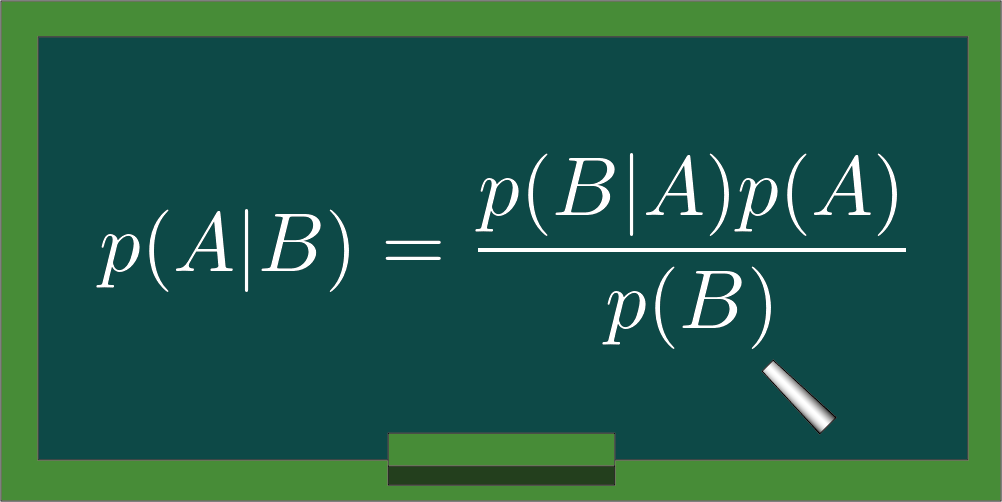




In [18]:
from collections import defaultdict

class GaussianNaiveBayes:
    alpha = None
    prop_classes = {}
    idx_classes = defaultdict() 
    num_of_words_classes = defaultdict()
    each_class_vectorizer = defaultdict()
    prop_each_classes_word = defaultdict()
    classes = None # y_train.unique()
    n_gram = None
    
    
    def __init__(self,n_gram):
        self.alpha = 1
        self.n_gram = n_gram
        
    def fit(self, X_train,y_train):
        
        self.words = X_train["words"]                            # list of all words in data
        self.classes = y_train.unique()
        num_of_distinct_words = len(self.words)                  # number of all words
        matrix_vectorizer_X_train = X_train["vectorizer"]        # vectorizer matrix
       
        self.prop_classes = dict(y_train.value_counts()/len(y_train))  # Oranların listesi
        
        for i in self.classes:
            idx  = y_train[y_train == i].index
            self.idx_classes[i] = idx                         # İndexlerin Sınıflara ayrılmış Listesi
       
       
       
        for i in self.classes:
            idx = self.idx_classes[i]
            count = 0
            for j in idx:
                count += np.sum(matrix_vectorizer_X_train.iloc[j])
                
            self.num_of_words_classes[i] = count  #'sport': 48222, 'business': 48503, 'politics': 49348, 'entertainment': 41560, 'tech': 53636}
        
        
        
   
        
        for i in self.classes:
            idx = self.idx_classes[i]
            each_class = matrix_vectorizer_X_train.iloc[idx]
            self.each_class_vectorizer[i] = each_class      #'sport': sport_vectorizer, 'business': business_vectorizer, ....... 'tech': tech_vectorizer}
        
        
        
        
        for i in self.classes:
            prop_each_classes_word = {word:0 for word in self.words}
            self.prop_each_classes_word[i] = prop_each_classes_word  # sport': sport_word_prob, ......  'tech': tech_word_prob}
            
        
        
        
        for word in self.words:
            for i in self.classes: 
                num_of_word_given_i = self.each_class_vectorizer[i][word].sum()
                prob_word_given_i = (num_of_word_given_i + self.alpha) / ( self.num_of_words_classes[i] + self.alpha * num_of_distinct_words)
                self.prop_each_classes_word[i][word] = prob_word_given_i
                
                
                
        
    def predict(self,X_test):        
        y_pred = list()        
    
    
        for element in X_test:
            
            p_each_class= defaultdict()
            
            if self.n_gram == "unigram":  
                list_of_instance_sentence = element.split(' ')
            elif self.n_gram == "bigram":
                words = element.split(" ")
                list_of_instance_sentence = []
                for i in range(0, len(words) - 1, 2):
                    pair = [words[i], words[i + 1]]
                    list_of_instance_sentence.append(pair)
          
            for i in self.classes:
                p_each = np.log(self.prop_classes[i])
                for word in list_of_instance_sentence:
                    if self.n_gram == "bigram":
                        word  = " ".join(word)
                    if word in  self.prop_each_classes_word[i]:
                        p_each += np.log(self.prop_each_classes_word[i][word])
                p_each_class[i] = p_each
                
        
            pred = max(p_each_class.items(), key=lambda a: a[1])[0]
            y_pred.append(pred)
                  
        return y_pred

We seperate the data with the ratio of 80/20 to generate X_train, X_test, y_train and y_test.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data["Text"], data["Category"], test_size=0.20, random_state=42)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

The prepare_X_train function arranges the X_train method to be used  Naive Bayes code according to the ngram_range and stop words we want

If ngram_range is (1,1), it means that X_train is unigram. 

Else ngram_range is(2,2), it means that X_train is bigram. 

If stop_words is none, then we dont remove stop words from X_train. 

Else stop_words is 'english', then we remove stop words.

In [20]:
def prepare_X_train(X_train, ngram_range ,stop_words):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words) # obtain BoW model (two option : bigram(2,2), unigram(1,1))
    matrix_vectorize = vectorizer.fit_transform(X_train)
    words_X_train = list(vectorizer.get_feature_names_out())
    matrix_vectorizer_X_train = pd.DataFrame(matrix_vectorize.toarray(), columns = list(words_X_train))
    X_train = {"words": words_X_train, "vectorizer" :matrix_vectorizer_X_train }
    return X_train

## Unigram without removing stopwords


Here, we train our unigram model without removing stopwords from X_train.

Then we calculate the model's accuracy, precision, recall and f1 score values.

In [21]:
X_train_unigram_without_stop_words = prepare_X_train(X_train,(1,1),stop_words= None)

model = GaussianNaiveBayes(n_gram="unigram")

model.fit(X_train_unigram_without_stop_words,y_train)

y_pred = model.predict(X_test)


print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred,average="macro"))
print("Recall: " ,recall_score(y_test,y_pred,average="macro"))
print("F1 Score: ", f1_score(y_test,y_pred,average="macro"))


Accuracy:  0.9731543624161074
Precision:  0.9738560193587418
Recall:  0.9728311558506462
F1 Score:  0.9732468965054778


## Unigram with removing stopwords

Here, we train our unigram model with removing stopwords from X_train.

Then we calculate the model's accuracy, precision, recall and f1 score values.

In [22]:
X_train_unigram_with_stop_words = prepare_X_train(X_train,(1,1),stop_words= "english")

model = GaussianNaiveBayes(n_gram="unigram")

model.fit(X_train_unigram_with_stop_words,y_train)

y_pred = model.predict(X_test)

print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred,average="macro"))
print("Recall: " ,recall_score(y_test,y_pred,average="macro"))
print("F1 Score: ", f1_score(y_test,y_pred,average="macro"))


Accuracy:  0.9765100671140939
Precision:  0.977243799153055
Recall:  0.976279431712715
F1 Score:  0.9767227552226027


## Bigram without removing stopwords

Here, we train our bigram model without removing stopwords from X_train.

Then we calculate the model's accuracy, precision, recall and f1 score values.

In [23]:
X_train_biagram_without_stop_words = prepare_X_train(X_train,(2,2),stop_words= None)

model = GaussianNaiveBayes(n_gram="bigram")

model.fit(X_train_biagram_without_stop_words,y_train)

y_pred = model.predict(X_test)

print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred,average="macro"))
print("Recall: " ,recall_score(y_test,y_pred,average="macro"))
print("F1 Score: ", f1_score(y_test,y_pred,average="macro"))

Accuracy:  0.9463087248322147
Precision:  0.9497162294566766
Recall:  0.9424335689298209
F1 Score:  0.9441044114249373


## Bigram with removing stopwords

Here, we train our bigram model with removing stopwords from X_train.

Then we calculate the model's accuracy, precision, recall and f1 score values.

In [24]:
X_train_biagram_with_stop_words = prepare_X_train(X_train,(2,2),stop_words= "english")

model = GaussianNaiveBayes(n_gram="bigram")

model.fit(X_train_biagram_with_stop_words,y_train)

y_pred = model.predict(X_test)

print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred,average="macro"))
print("Recall: " ,recall_score(y_test,y_pred,average="macro"))
print("F1 Score: ", f1_score(y_test,y_pred,average="macro"))

Accuracy:  0.9463087248322147
Precision:  0.9470623418449506
Recall:  0.9468579995716426
F1 Score:  0.9464885414435639


# Part 3:

## 3.1 Analyzing effect of the words on prediction

get_frequency_data function calculates the frequencies of the words for each unique categories with using tf-idf algorithm.

frequency_presence is a list that keeps most common words appeared in each unique categories.

frequency_absence is a list that keeps least common words appeared in each unique categories.

In [25]:
def get_frequency_data(x, stop_value=None):
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stop_value)
    matrix_vectorize = vectorizer.fit_transform(x)
    words = list(vectorizer.get_feature_names_out())
    tf_idf = TfidfTransformer()
    words_tf_tdf = tf_idf.fit(matrix_vectorize).idf_
    frequency = dict(zip(words, words_tf_tdf))
    frequency = dict(sorted(frequency.items(), key=lambda item: item[1]))
    return frequency  # frequency based calculation with TF-IDF

In [26]:
frequency_presence = defaultdict()
frequency_absence = defaultdict()
for i in data.Category.unique():
    frequency_class = get_frequency_data(data[data.Category == i].Text)
    frequency_presence[i] = list(frequency_class.items())[:10]
    frequency_absence[i] = list(frequency_class.items())[-10:]

Below is 10 words whose presence most strongly predicts that the article belongs to specific category for each five categories.

In [27]:
#Ten presence word
tf_idf_presence_word = pd.DataFrame.from_dict(frequency_presence)
tf_idf_presence_word

,business,tech,politics,sport,entertainment
0,"(of, 1.0)","(and, 1.0)","(in, 1.0)","(the, 1.0)","(the, 1.0)"
1,"(the, 1.0)","(the, 1.0)","(the, 1.0)","(to, 1.0028860048891348)","(in, 1.0036563112031105)"
2,"(to, 1.0)","(to, 1.0)","(to, 1.0)","(in, 1.014514042884254)","(of, 1.007326040092073)"
3,"(in, 1.0029717703891574)","(of, 1.0076628727455692)","(and, 1.0072993024816115)","(of, 1.014514042884254)","(and, 1.0110092855083694)"
4,"(and, 1.0119404403719179)","(in, 1.019268418865877)","(of, 1.0072993024816115)","(and, 1.0174423026633423)","(to, 1.018416726786231)"
5,"(said, 1.0802900181731276)","(that, 1.0270809586026706)","(on, 1.052250690343878)","(for, 1.0904230060695785)","(on, 1.0679506619085077)"
6,"(for, 1.0964978283999811)","(it, 1.0310102367425602)","(is, 1.0560894666510436)","(but, 1.1290130033394477)","(for, 1.07973861766055)"
7,"(that, 1.1229894438469572)","(is, 1.0389154162496737)","(for, 1.0599430359670337)","(on, 1.1422145151979834)","(was, 1.1837824774336294)"
8,"(it, 1.1263507915496622)","(for, 1.0428915646293129)","(be, 1.0676950127713514)","(at, 1.1623494236070395)","(has, 1.1970277041836501)"
9,"(is, 1.1365031630136802)","(be, 1.0877055804191054)","(said, 1.075507552508145)","(with, 1.1863642998109132)","(with, 1.2104507245157907)"


Below is 10 words whose absence most strongly predicts that the article belongs to specific category for each five categories.

In [28]:
#Ten absence word
tf_idf_absence_word = pd.DataFrame.from_dict(frequency_absence)
tf_idf_absence_word

,business,tech,politics,sport,entertainment
0,"(yukon, 6.126935749792416)","(yusuf, 5.875197323201151)","(yoga, 5.923623917106626)","(zambia, 6.156177599386914)","(zephaniah, 5.919980925828125)"
1,"(yulia, 6.126935749792416)","(zar, 5.875197323201151)","(yorker, 5.923623917106626)","(zara, 6.156177599386914)","(zero, 5.919980925828125)"
2,"(yungmin, 6.126935749792416)","(zdnet, 5.875197323201151)","(youngster, 5.923623917106626)","(zealousness, 6.156177599386914)","(zimbabwe, 5.919980925828125)"
3,"(yuri, 6.126935749792416)","(zed, 5.875197323201151)","(youngsters, 5.923623917106626)","(zheng, 6.156177599386914)","(zoe, 5.919980925828125)"
4,"(yury, 6.126935749792416)","(zens, 5.875197323201151)","(yourself, 5.923623917106626)","(zib, 6.156177599386914)","(zola, 5.919980925828125)"
5,"(zack, 6.126935749792416)","(zip, 5.875197323201151)","(youths, 5.923623917106626)","(ziers, 6.156177599386914)","(zombie, 5.919980925828125)"
6,"(zardari, 6.126935749792416)","(zodiac, 5.875197323201151)","(yushchenko, 5.923623917106626)","(zimbabwe, 6.156177599386914)","(zone, 5.919980925828125)"
7,"(zinc, 6.126935749792416)","(zombie, 5.875197323201151)","(yvette, 5.923623917106626)","(zoe, 6.156177599386914)","(zooropa, 5.919980925828125)"
8,"(zoellick, 6.126935749792416)","(zonealarm, 5.875197323201151)","(zambian, 5.923623917106626)","(zola, 6.156177599386914)","(zorro, 5.919980925828125)"
9,"(zones, 6.126935749792416)","(zones, 5.875197323201151)","(zone, 5.923623917106626)","(zuluaga, 6.156177599386914)","(zutons, 5.919980925828125)"


## 3.2 Analyzing effect of the non-stopwords

get_frequency_data_of_nonstopwords function calculates the frequencies of the words for each unique categories with removing stop words.

frequency_nonstopwords is a list that keeps most common words appeared in each unique categories when we remove stop words.

In [29]:
def get_frequency_data_of_nonstopwords(x, stop_value="english"):
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stop_value)
    matrix_vectorize = vectorizer.fit_transform(x)
    words = list(vectorizer.get_feature_names_out())
    tf_idf = TfidfTransformer()
    words_tf_tdf = tf_idf.fit(matrix_vectorize).idf_
    frequency = dict(zip(words, words_tf_tdf))
    frequency = dict(sorted(frequency.items(), key=lambda item: item[1]))
    return frequency  # frequency based calculation with TF-IDF

In [30]:
frequency_nonstopwords = defaultdict()
for i in data.Category.unique():
    frequency_class_nonstopwords = get_frequency_data_of_nonstopwords(data[data.Category == i].Text)
    frequency_nonstopwords[i] = list(frequency_class_nonstopwords.items())[:10]

In [31]:
tf_idf_nonstopwords = pd.DataFrame.from_dict(frequency_nonstopwords)
tf_idf_nonstopwords

,business,tech,politics,sport,entertainment
0,"(said, 1.0802900181731276)","(said, 1.1259267932393033)","(said, 1.075507552508145)","(said, 1.2546134003450202)","(said, 1.2950081125438537)"
1,"(year, 1.449444902224699)","(people, 1.29534494519735)","(mr, 1.2414926899824064)","(year, 1.6182161630922725)","(year, 1.4598365118902912)"
2,"(new, 1.7962024095060853)","(new, 1.4623990298605163)","(government, 1.3964152725882464)","(time, 1.67317504737303)","(film, 1.7004732206520181)"
3,"(market, 1.8572383000924546)","(use, 1.7085320993994246)","(people, 1.5798184952529422)","(win, 1.7194260650237858)","(new, 1.776846199436592)"
4,"(company, 1.8713230399741934)","(year, 1.7163142398414797)","(minister, 1.6469577980905707)","(game, 1.8058996630276125)","(best, 1.949689012276003)"
5,"(firm, 1.9148081519139324)","(technology, 1.7643234590278403)","(labour, 1.6895174125093666)","(world, 1.9440500015084297)","(star, 2.0180082562534802)"
6,"(mr, 1.9448856071512104)","(make, 1.7725539581643557)","(election, 1.7415737744654196)","(just, 1.9741274567457077)","(including, 2.113318436057805)"
7,"(chief, 2.0751508019891114)","(way, 1.7725539581643557)","(new, 1.7647408337469541)","(old, 2.0453037352136025)","(time, 2.113318436057805)"
8,"(2004, 2.092695111640021)","(mr, 1.7808527609790508)","(party, 1.8045867422941537)","(won, 2.053534234350118)","(uk, 2.1244917366559304)"
9,"(years, 2.1105527290400277)","(like, 1.8061705689633407)","(told, 1.8127500529333147)","(team, 2.0702012868353297)","(years, 2.1357912919098636)"


### 3.2.1 Analyzing effect of the stopwords:

Removing stop words makes really sense because it makes our prediction more meaningful. If you analyze the table without removing stop words("tf_idf_presence_word"), you can see that almost all of the outputs are consisted of stop words and this makes almost impossible to predict the category. If you analyze the table with removing the stop words("tf_idf_nonstopwords"), you can see that almost all of the outputs are different for different catagories and they are meaningful. By removing stop words, every people can predict the category just for looking to the data.

# Part 4 : Conclusion 



## 4.1 Analysis of accuracy :

As you can see from the tables in part2, accuracy values are as fallows:

Accuracy of unigram model without removing stop words : 0.9731543624161074 

Accuracy of unigram model with removing stop words : 0.9765100671 140939

Accuracy of bigram model without removing stop words : 0.9463087248322147

Accuracy of bigram model with removing stop words : 0.9463087248322147

By analyzing these values, we can say that unigram models have better accuracy values than bigram models. Also we can say that removing stop words increased the accuracy value for unigram model but it didn't make any effect on bigram models.

In addition, because the bigram model takes words in pairs, it comes up with a slower algorithm compared to the unigram model.

## 4.2 Algorithm Speed Test

In [35]:
X_train_unigram_with_stop_words = prepare_X_train(X_train,(1,1),stop_words= None)


model = GaussianNaiveBayes(n_gram="unigram")

start_time = time.time()

model.fit(X_train_biagram_with_stop_words,y_train)

start2_time = time.time()

x = start2_time - start_time

print("Model Fit Time :", x)

start_time= time.time()

y_pred = model.predict(X_test)

start2_time = time.time()

x = start2_time - start_time

print("Model Predict Time: " , x)


Model Fit Time : 25.000730991363525
Model Predict Time:  0.05440831184387207


# 5. References

https://web.cs.hacettepe.edu.tr/~abc/teaching/bbm406/index.php

https://stackoverflow.com

https://theflyingmantis.medium.com/text-classification-in-nlp-naive-bayes-a606bf419f8c